**Dataset**
 
DRIVE: Digital Retinal Images for Vessel Extraction
- [main page](https://drive.grand-challenge.org/)
- [donwload link](https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel)

In [1]:
import os 
os.chdir("..")
os.listdir()


['config',
 'tests',
 'scripts',
 '.gitignore',
 '.git',
 'one_ring',
 'logs',
 '.vscode',
 't.md',
 'README.md',
 'env',
 'board_logs',
 'examples',
 'setup.py',
 'mlruns',
 'models',
 'notebooks',
 'images',
 'runs',
 'notes.md',
 'data',
 'run_train.py',
 's.md',
 'support']

In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A


import tensorflow as tf
from tensorflow.keras.metrics import Recall,Precision

import one_ring
from one_ring.config import get_config
from one_ring.data import get_data_loader
from one_ring.transformers import Transformer
from one_ring.callbacks import ORLearningRateCallback
from one_ring.scheduler import ORLearningRateScheduler
from one_ring.losses import FocalTverskyLoss, DiceLoss,LogCoshDiceLoss,FocalLoss,SymmetricUnifiedFocalLoss,JaccardLoss,BoundaryDoULoss
from one_ring.metrics import DiceScore,JaccardScore
from one_ring.models import DeepLabV3Plus
from one_ring.train import Trainer
from one_ring.utils import generate_overlay_image,calculate_confusion_matrix_and_report


warnings.filterwarnings("always")

print(tf.__version__)
print(one_ring.__version__)


2024-09-16 02:27:33.017660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 02:27:33.017684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 02:27:33.018643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 02:27:33.023996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 02:27:33.708822: W tensorflow/compiler/tf2

2.15.0
0.1.0


In [3]:
config = get_config(config_filename="example_binary")
#cfg = config["augmentation"]

IMG_SIZE = config.data["image_size"][0]
aug_config = {
    "aug_prob": 0.5,
    "rotate_limit": 25,
    "img_size": IMG_SIZE
}

**Note**: to train with one_ring, you need dataset with special format like yolo, checks exaample data structure in `data/`

In [4]:
train_data_loader, val_data_loader = get_data_loader(config.data, train_data=True, val_data=True, test_data=False)

2024-09-16 02:27:34.766100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-16 02:27:34.793792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-16 02:27:34.793934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-09-16 02:27:35.030601: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


train data shape : (4, 224, 224, 3), data type : <class 'tensorflow.python.framework.ops.EagerTensor'>
target data shape : (4, 224, 224, 1), data type : <class 'tensorflow.python.framework.ops.EagerTensor'>


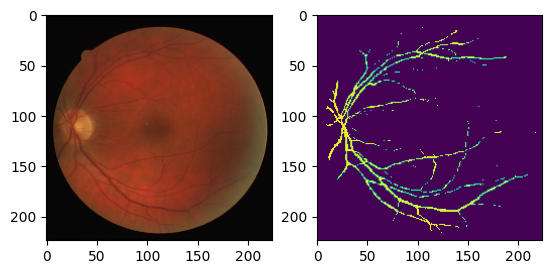

In [5]:
# no transformer 
for i in train_data_loader.load_data():
    print(f"train data shape : {i[0].shape}, data type : {type(i[0])}")
    print(f"target data shape : {i[1].shape}, data type : {type(i[1])}")
    break


plt.subplot(1,2,1)
plt.imshow(i[0][0].numpy().astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(i[1][0].numpy().astype(np.uint8))



**transformer part**

In [6]:
# for  efficientnet, tensorflow efficientnet input data must not be normalized
train_transforms = A.Compose([
    A.Resize(aug_config["img_size"], aug_config["img_size"]),
    A.HorizontalFlip(p=aug_config["aug_prob"]),
    A.Rotate(limit=aug_config["rotate_limit"], p=aug_config["aug_prob"]),
    A.RandomResizedCrop(
        height=aug_config["img_size"], 
        width=aug_config["img_size"], 
        scale=(0.95, 1.0),  # Gentler crop
        p=aug_config["aug_prob"]
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=aug_config["aug_prob"]
    ),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.05, 
        rotate_limit=15, 
        p=aug_config["aug_prob"]
    ),
])

test_transforms = A.Compose(
    [
        A.Resize(aug_config["img_size"], aug_config["img_size"]),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


**There is two options to create transformer objects: scratch and from_dict**

In [7]:
tr_transforms_object = Transformer(config.augmentation, "train", train_transforms)#.from_dict()
ts_transforms_object = Transformer(config.augmentation, "test", test_transforms)#.from_dict()

train_dataset = train_data_loader.load_data(transform_func=tr_transforms_object)
val_dataset = val_data_loader.load_data(transform_func=ts_transforms_object, shuffle=False)

# to save as meta data
save_object = {
    "transformer":{
        "train":tr_transforms_object.to_dict(),
        "val": ts_transforms_object.to_dict()
    }
}


train data shape : (4, 224, 224, 3), data type : <class 'tensorflow.python.framework.ops.EagerTensor'>
target data shape : (4, 224, 224, 1), data type : <class 'tensorflow.python.framework.ops.EagerTensor'>


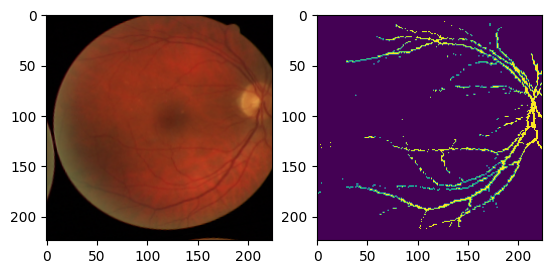

In [8]:
# with transformer 
for i in train_dataset:
    print(f"train data shape : {i[0].shape}, data type : {type(i[0])}")
    print(f"target data shape : {i[1].shape}, data type : {type(i[1])}")
    break

plt.subplot(1,2,1)
plt.imshow(i[0][0].numpy().astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(i[1][0].numpy().astype(np.uint8))

**callbacks**

In [9]:
callbacks = {}

steps_per_epoch = len(train_dataset)
lr_schedule = ORLearningRateScheduler(
    strategy=config.train.lr_scheduler["name"],
    total_epochs=config.train.epochs,
    steps_per_epoch=steps_per_epoch,
    **config.train.lr_scheduler["params"]
).get()
callbacks["lr_sch"] = ORLearningRateCallback(lr_schedule)

log_dir = f"board_logs/{config.train.experiment_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks["tensorboard"] = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_images=True, write_graph=True, update_freq='epoch')#, profile_batch='500,520')

**loss function and metrics** 


In [10]:

tf.keras.backend.clear_session()
loss_name = "boundary_dou_loss"
params = {
    "gamma": 4/3,
    "alpha": 0.4,
    "loss_weight": 0.4
}



loss_dict = {
    "focal_loss": FocalLoss,
    "dice_loss": DiceLoss,
    "jaccard_loss": JaccardLoss,
    "log_cosh_dice_loss": LogCoshDiceLoss,
    "focal_tversky_loss": FocalTverskyLoss,
    "symmetric_unified_focal_loss": SymmetricUnifiedFocalLoss,
    "boundary_dou_loss": BoundaryDoULoss
}

metrics_dict= {
    "recal":Recall,
    "precision":Precision,
    "jaccard_score":JaccardScore,
    "dice_score":DiceScore,
}

loss = loss_dict[loss_name](**params)
metrics = [m() for m in metrics_dict.values()]
callbacks = list(callbacks.values())


In [11]:
#model = AttUnet(**config.model).build_model()
#model = Unet(**config.model).build_model()
model = DeepLabV3Plus(**config.model).build_model()

model.summary()
#keras.utils.plot_model(model, show_shapes=True, to_file=f'{model.name}_model.png')


32

Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 EfficientNetB0_backbone (F  [(None, 56, 56, 144),        945927    ['input[0][0]']               
 unctional)                   (None, 14, 14, 672)]                                                
                                                                                                  
 aspp (AtrousSpatialPyramid  (None, 14, 14, 160)          652480    ['EfficientNetB0_backbone[0][1
 Pooling)                                                           ]']                           
                                                                                  

In [12]:
trainer = Trainer(config, model, train_dataset, val_dataset, callbacks=callbacks, metrics=metrics,loss=loss,save_object=save_object)

/home/tuvis/tff/tf_seg/one_ring/logger.py:37: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/tuvis/tff/tf_seg/logs/trainer_log.log' mode='a' encoding='UTF-8'>
  logger.handlers = []


In [14]:
history = trainer.fit()

2024-09-16 02:29:31,204 - one_ring - INFO - Epoch 21 - New best model found with validation loss: 0.3919
2024-09-16 02:29:31,207 - one_ring - INFO - Epoch 21/40 - 1.53s - loss: 0.4104 - recall: 0.6155 - precision: 0.4904 - jaccard_score: 0.3754 - dice_score: 0.5446 - val_loss: 0.3919 - val_recall: 0.5897 - val_precision: 0.5411 - val_jaccard_score: 0.3919 - val_dice_score: 0.5623
2024-09-16 02:29:32,672 - one_ring - INFO - Epoch 22/40 - 1.46s - loss: 0.4046 - recall: 0.6271 - precision: 0.4956 - jaccard_score: 0.3818 - dice_score: 0.5517 - val_loss: 0.3939 - val_recall: 0.6472 - val_precision: 0.5037 - val_jaccard_score: 0.3943 - val_dice_score: 0.5646
2024-09-16 02:29:34,162 - one_ring - INFO - Epoch 23 - New best model found with validation loss: 0.3916
2024-09-16 02:29:34,164 - one_ring - INFO - Epoch 23/40 - 1.49s - loss: 0.4061 - recall: 0.6194 - precision: 0.4952 - jaccard_score: 0.3788 - dice_score: 0.5483 - val_loss: 0.3916 - val_recall: 0.5871 - val_precision: 0.5408 - val_jac

In [15]:
# finish training and save modeli with best weights and end mlflow run
trainer.finalize_training()

# load best model
#trainer.load(trainer.save_path,setup_components=True)

2024-09-16 02:30:06,679 - one_ring - INFO - Restored best model weights.


INFO:tensorflow:Assets written to: models/20240916022744/saved_model/assets


INFO:tensorflow:Assets written to: models/20240916022744/saved_model/assets
2024-09-16 02:30:19,881 - one_ring - INFO - Saved TensorFlow model to models/20240916022744/saved_model
INFO:one_ring:Saved TensorFlow model to models/20240916022744/saved_model
2024-09-16 02:30:19,889 - one_ring - INFO - Saved metadata to models/20240916022744/meta_data
INFO:one_ring:Saved metadata to models/20240916022744/meta_data
2024-09-16 02:30:20.462220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-16 02:30:20.462324: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-09-16 02:30:20.462378: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
202

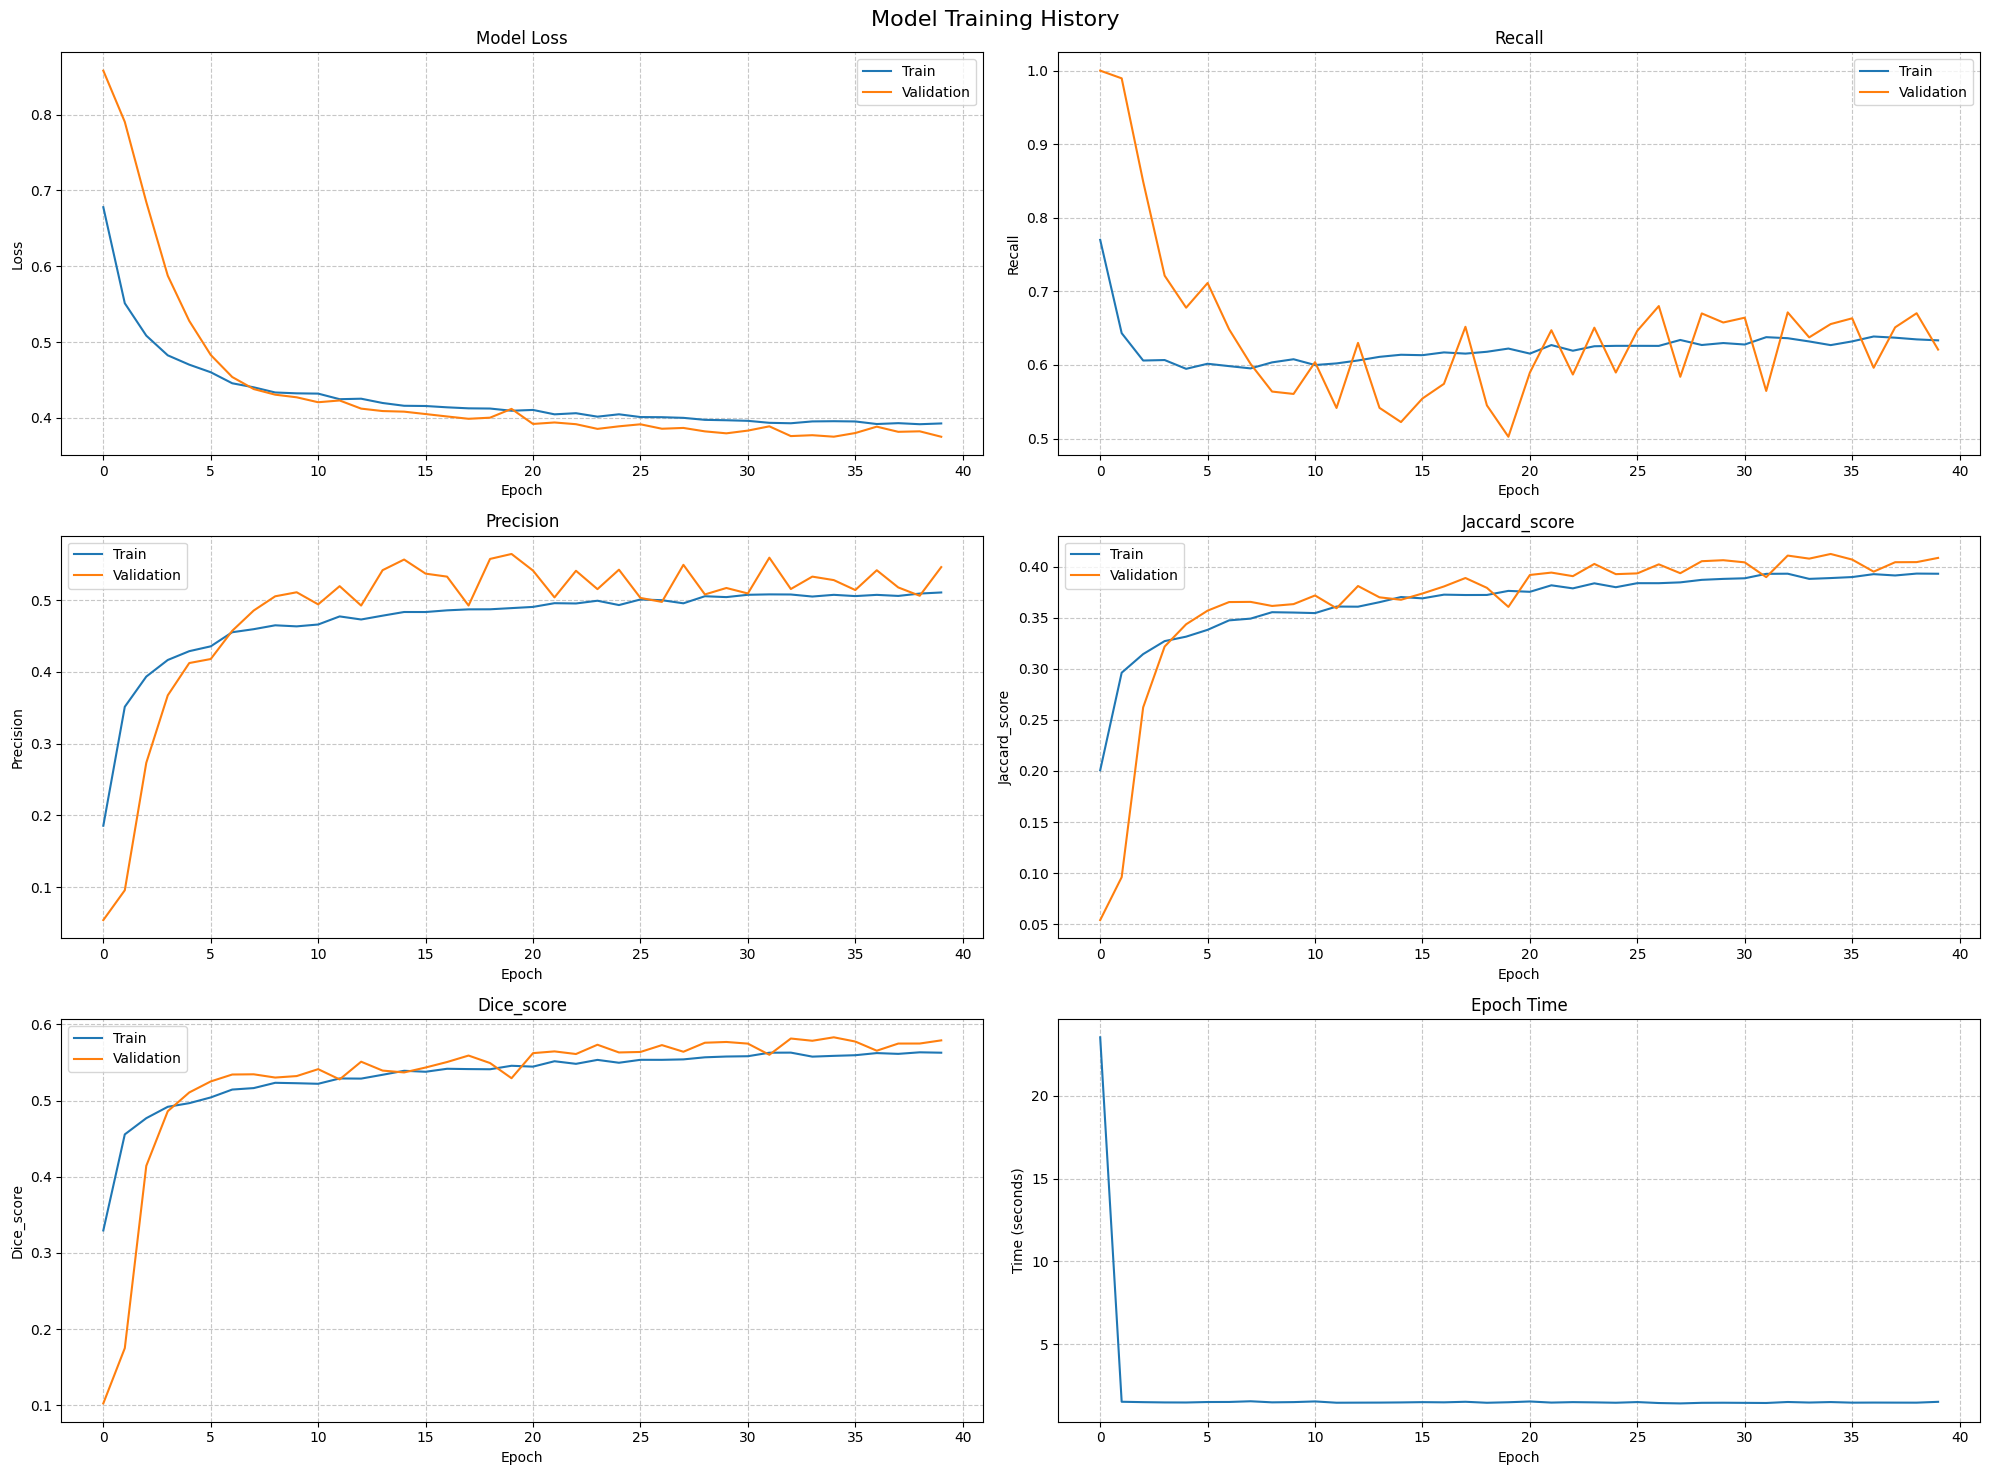

Final training loss: 0.3926
Final validation loss: 0.3751
Final training recall: 0.6335
Final validation recall: 0.6209
Final training precision: 0.5106
Final validation precision: 0.5459
Final training jaccard_score: 0.3931
Final validation jaccard_score: 0.4086
Final training dice_score: 0.5629
Final validation dice_score: 0.5791
Average epoch time: 2.03 seconds


In [16]:
def plot_history(history, figsize=(20, 15)):
    """
    Plot training history of a custom model with dynamic metrics and grid lines.

    Parameters:
    -----------
    history : dict
        The history dictionary containing training metrics
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (20, 15).

    Returns:
    --------
    None
        Displays the plot.
    """
    # Determine the number of metrics
    n_metrics = len(history['metrics']) + 1  # +1 for loss
    n_rows = (n_metrics + 1) // 2  # +1 for epoch time
    
    # Create subplots
    fig, axs = plt.subplots(n_rows, 2, figsize=figsize)
    fig.suptitle('Model Training History', fontsize=16)
    
    # Flatten axs for easier indexing
    axs = axs.flatten()
    
    # Plot training & validation loss
    axs[0].plot(history['loss'], label='Train')
    axs[0].plot(history['val_loss'], label='Validation')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot other metrics
    for i, metric in enumerate(history['metrics'].keys(), start=1):
        axs[i].plot(history['metrics'][metric], label='Train')
        axs[i].plot(history['val_metrics'][metric], label='Validation')
        axs[i].set_title(metric.capitalize())
        axs[i].set_ylabel(metric.capitalize())
        axs[i].set_xlabel('Epoch')
        axs[i].legend()
        axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Plot Epoch Time
    axs[-1].plot(history['epoch_time'])
    axs[-1].set_title('Epoch Time')
    axs[-1].set_ylabel('Time (seconds)')
    axs[-1].set_xlabel('Epoch')
    axs[-1].grid(True, linestyle='--', alpha=0.7)
    
    # Remove any unused subplots
    for i in range(n_metrics + 1, len(axs)):
        fig.delaxes(axs[i])
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print final values
    print(f"Final training loss: {history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
    
    for metric in history['metrics'].keys():
        print(f"Final training {metric}: {history['metrics'][metric][-1]:.4f}")
        print(f"Final validation {metric}: {history['val_metrics'][metric][-1]:.4f}")
    
    print(f"Average epoch time: {np.mean(history['epoch_time']):.2f} seconds")


plot_history(history)


In [17]:
# best model
model = trainer.model


1/1 [==============================] - 2s 2s/step


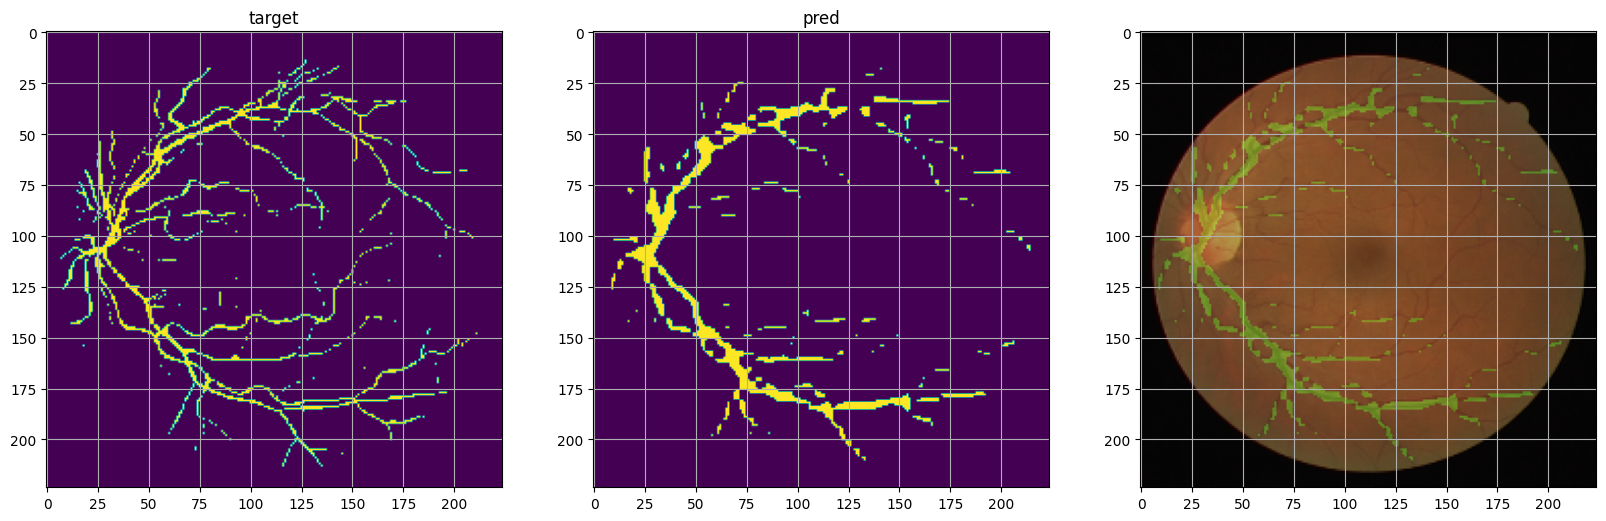

[[46382  1110]
 [ 1375  1309]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     47492
         1.0       0.54      0.49      0.51      2684

    accuracy                           0.95     50176
   macro avg       0.76      0.73      0.74     50176
weighted avg       0.95      0.95      0.95     50176



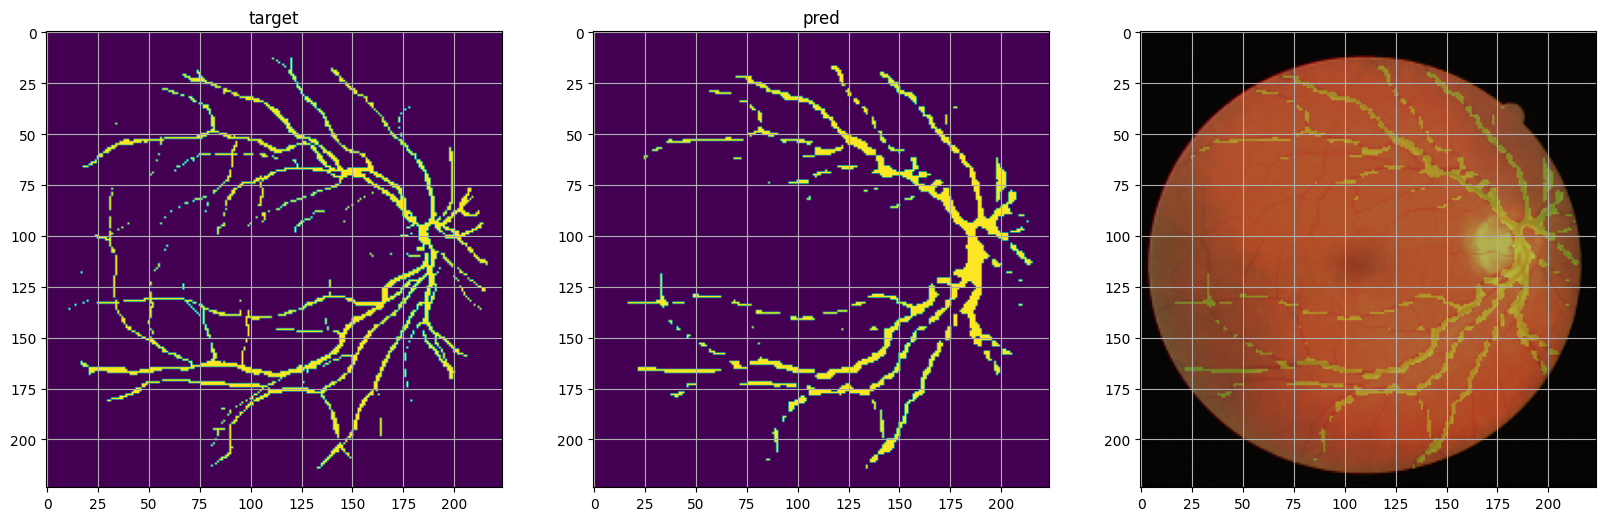

[[45719  1138]
 [ 1408  1911]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     46857
         1.0       0.63      0.58      0.60      3319

    accuracy                           0.95     50176
   macro avg       0.80      0.78      0.79     50176
weighted avg       0.95      0.95      0.95     50176



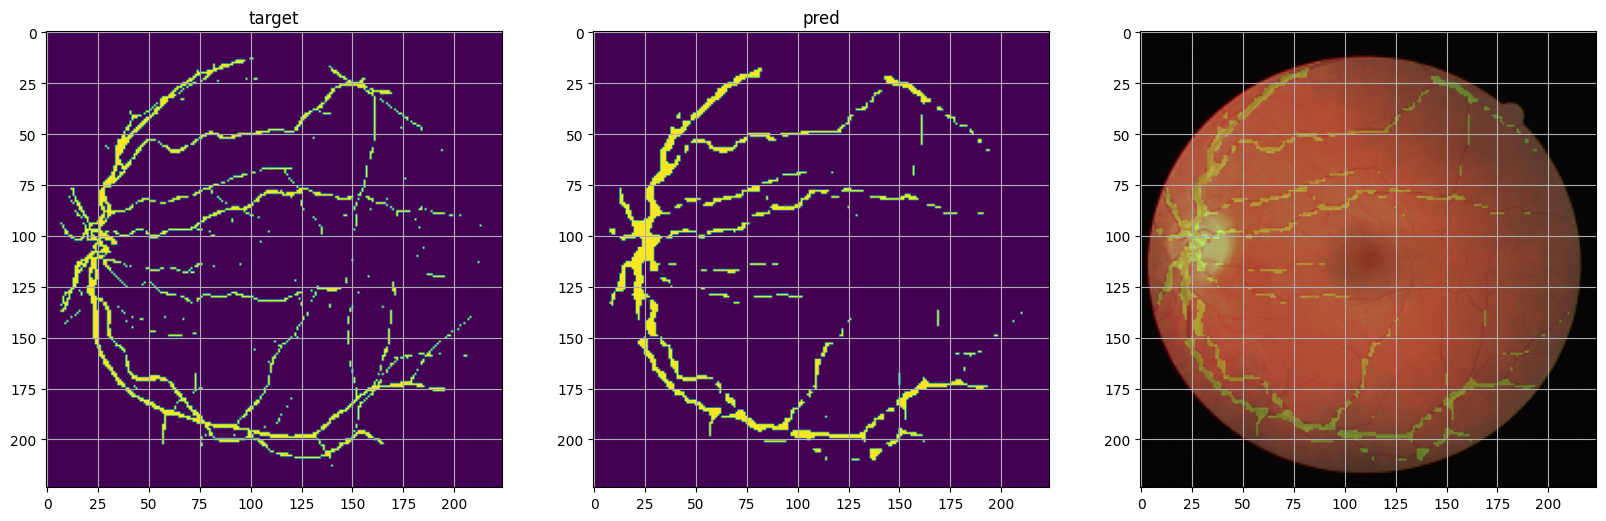

[[46636   960]
 [ 1106  1474]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47596
         1.0       0.61      0.57      0.59      2580

    accuracy                           0.96     50176
   macro avg       0.79      0.78      0.78     50176
weighted avg       0.96      0.96      0.96     50176



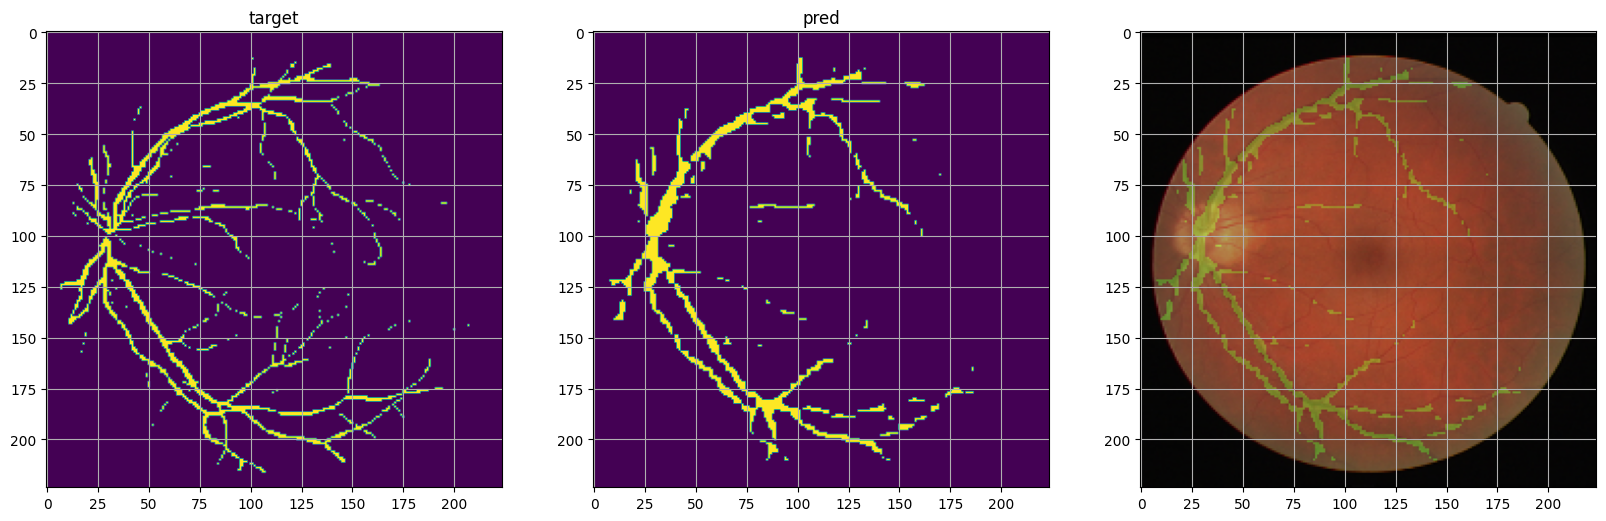

[[46580   937]
 [ 1139  1520]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47517
         1.0       0.62      0.57      0.59      2659

    accuracy                           0.96     50176
   macro avg       0.80      0.78      0.79     50176
weighted avg       0.96      0.96      0.96     50176

1/1 [==============================] - 0s 17ms/step


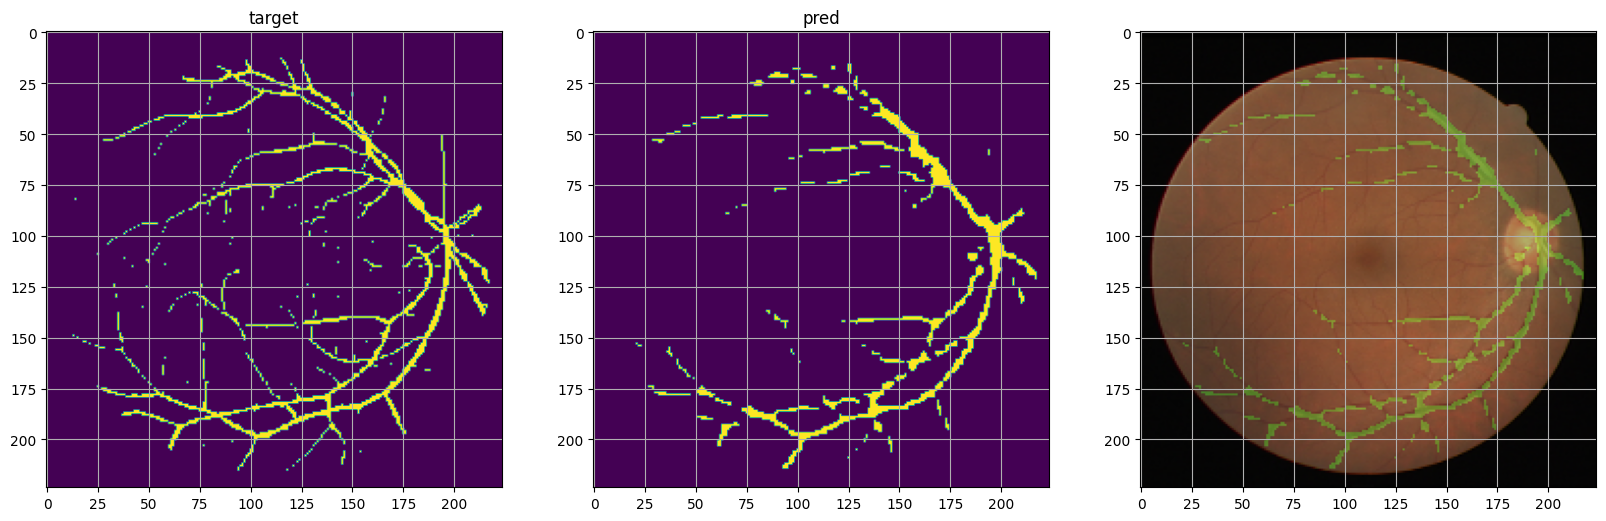

[[46554   719]
 [ 1417  1486]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     47273
         1.0       0.67      0.51      0.58      2903

    accuracy                           0.96     50176
   macro avg       0.82      0.75      0.78     50176
weighted avg       0.95      0.96      0.95     50176



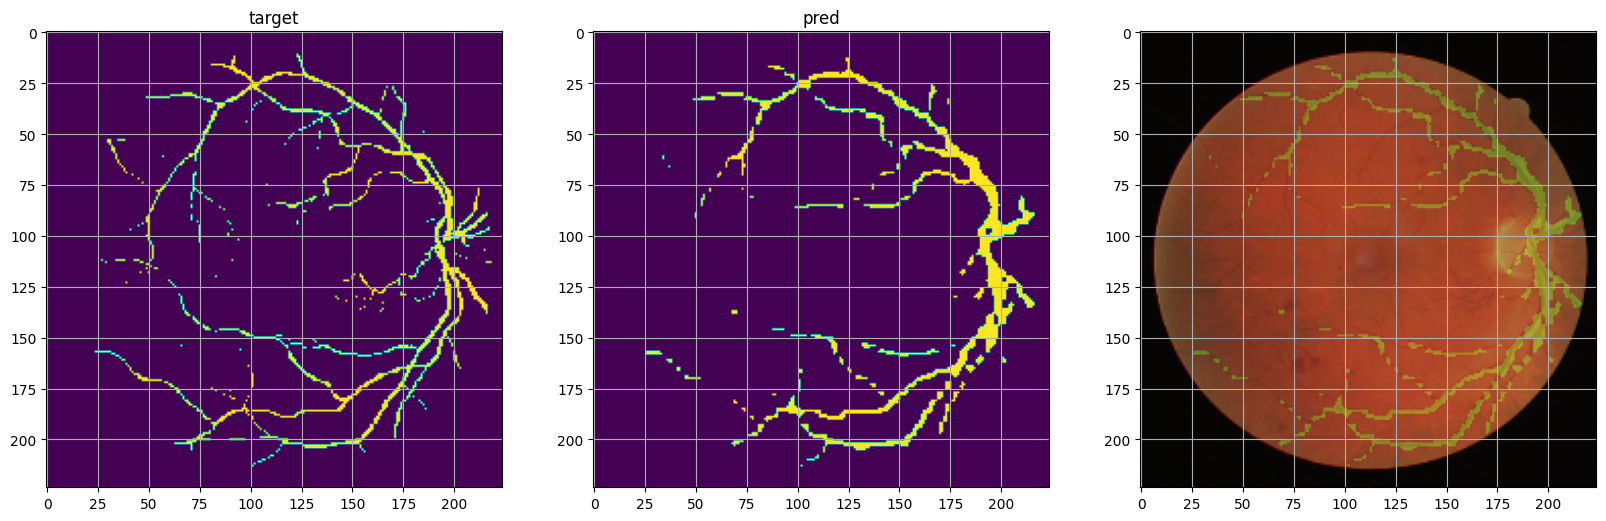

[[46666  1114]
 [  898  1498]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47780
         1.0       0.57      0.63      0.60      2396

    accuracy                           0.96     50176
   macro avg       0.78      0.80      0.79     50176
weighted avg       0.96      0.96      0.96     50176



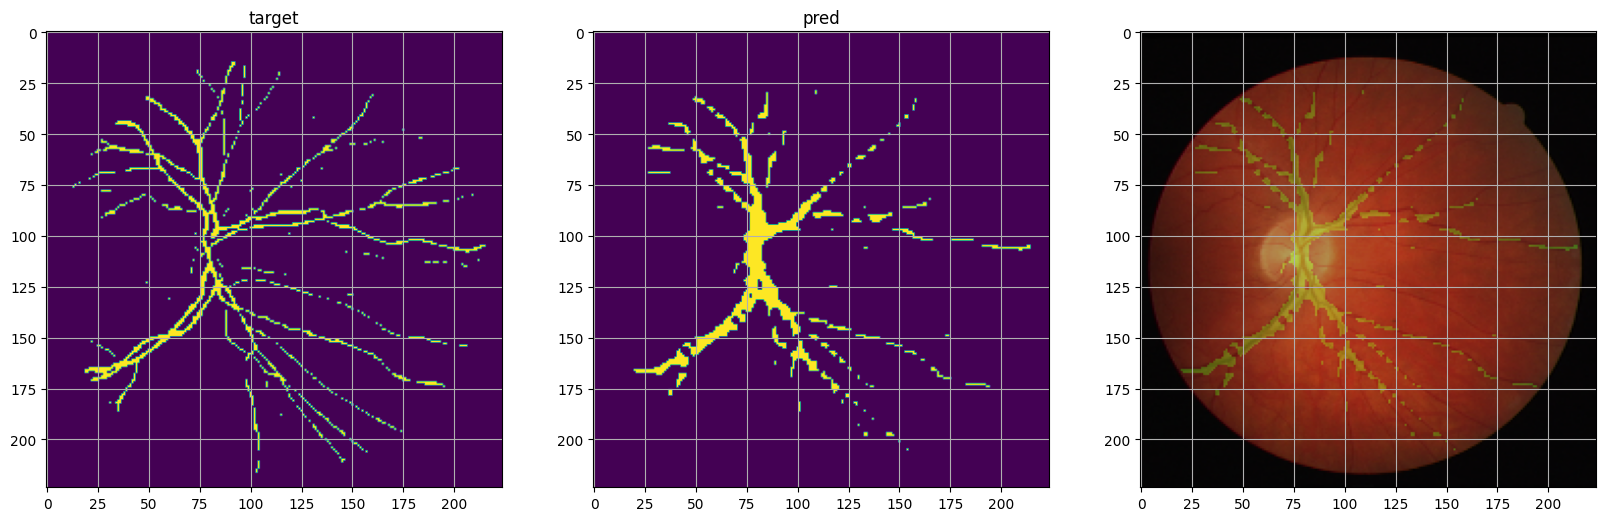

[[47093  1002]
 [ 1066  1015]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     48095
         1.0       0.50      0.49      0.50      2081

    accuracy                           0.96     50176
   macro avg       0.74      0.73      0.74     50176
weighted avg       0.96      0.96      0.96     50176



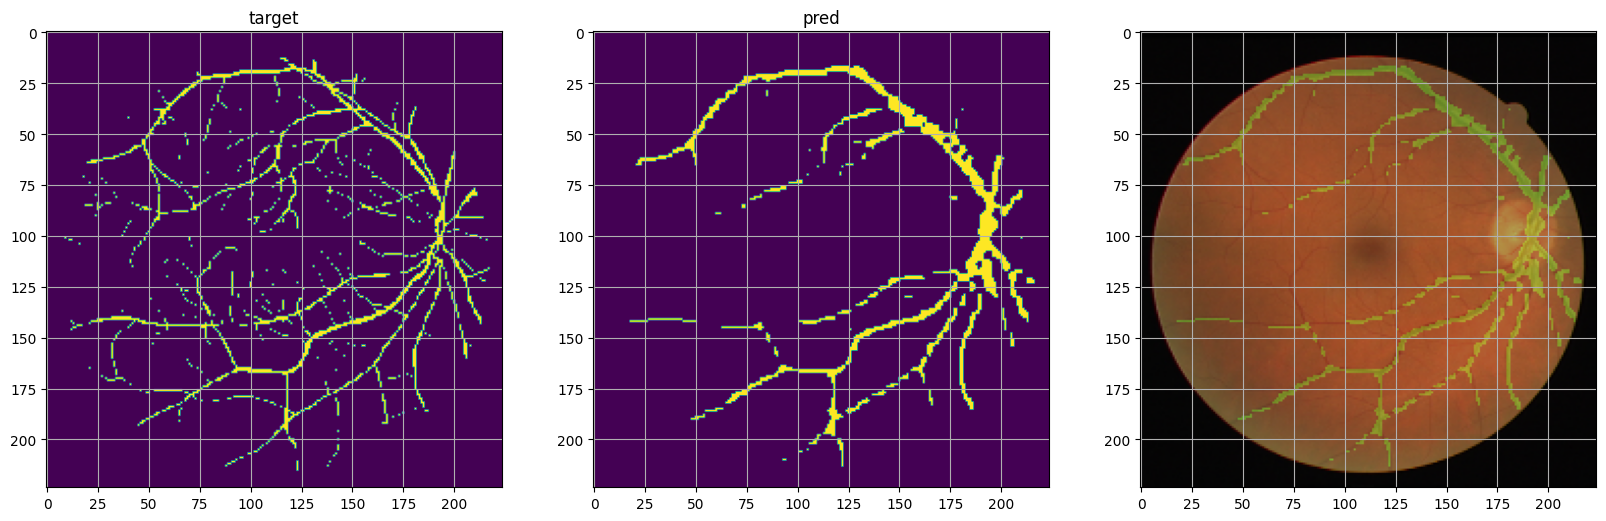

[[46142  1269]
 [ 1343  1422]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     47411
         1.0       0.53      0.51      0.52      2765

    accuracy                           0.95     50176
   macro avg       0.75      0.74      0.75     50176
weighted avg       0.95      0.95      0.95     50176

1/1 [==============================] - 0s 17ms/step


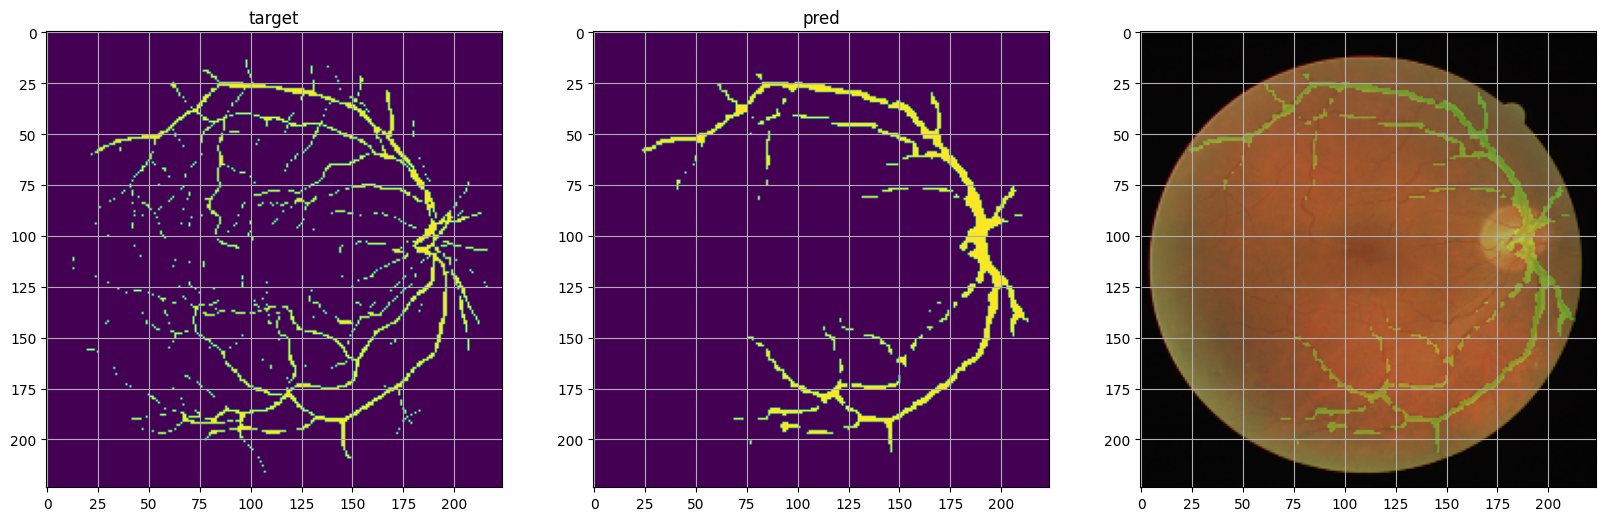

[[46630   961]
 [ 1277  1308]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     47591
         1.0       0.58      0.51      0.54      2585

    accuracy                           0.96     50176
   macro avg       0.77      0.74      0.76     50176
weighted avg       0.95      0.96      0.95     50176



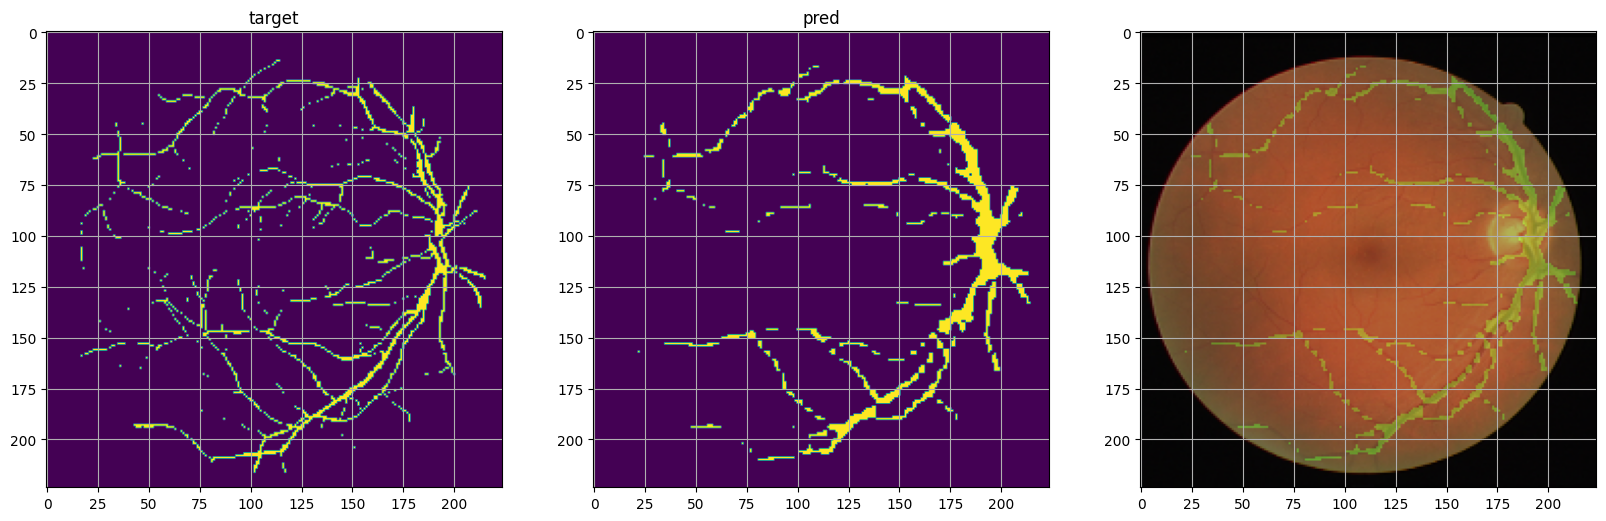

[[46490  1281]
 [ 1132  1273]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     47771
         1.0       0.50      0.53      0.51      2405

    accuracy                           0.95     50176
   macro avg       0.74      0.75      0.74     50176
weighted avg       0.95      0.95      0.95     50176



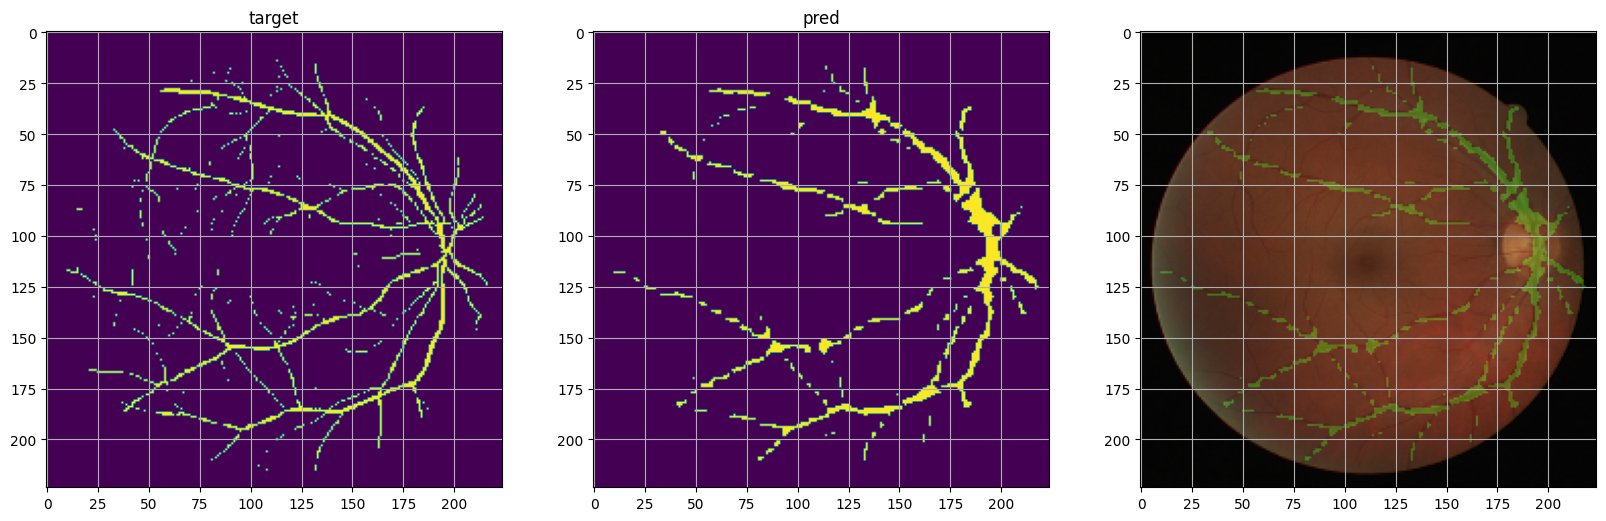

[[46692  1075]
 [ 1120  1289]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47767
         1.0       0.55      0.54      0.54      2409

    accuracy                           0.96     50176
   macro avg       0.76      0.76      0.76     50176
weighted avg       0.96      0.96      0.96     50176



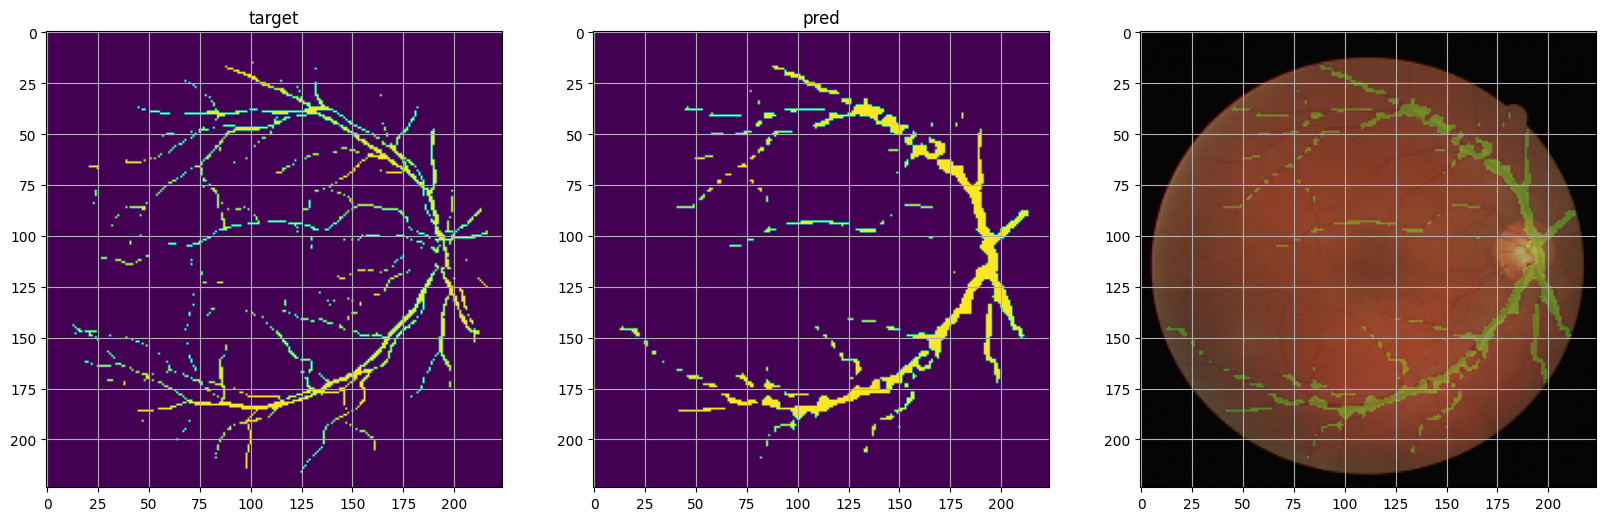

[[46716  1241]
 [ 1039  1180]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     47957
         1.0       0.49      0.53      0.51      2219

    accuracy                           0.95     50176
   macro avg       0.73      0.75      0.74     50176
weighted avg       0.96      0.95      0.96     50176

1/1 [==============================] - 0s 17ms/step


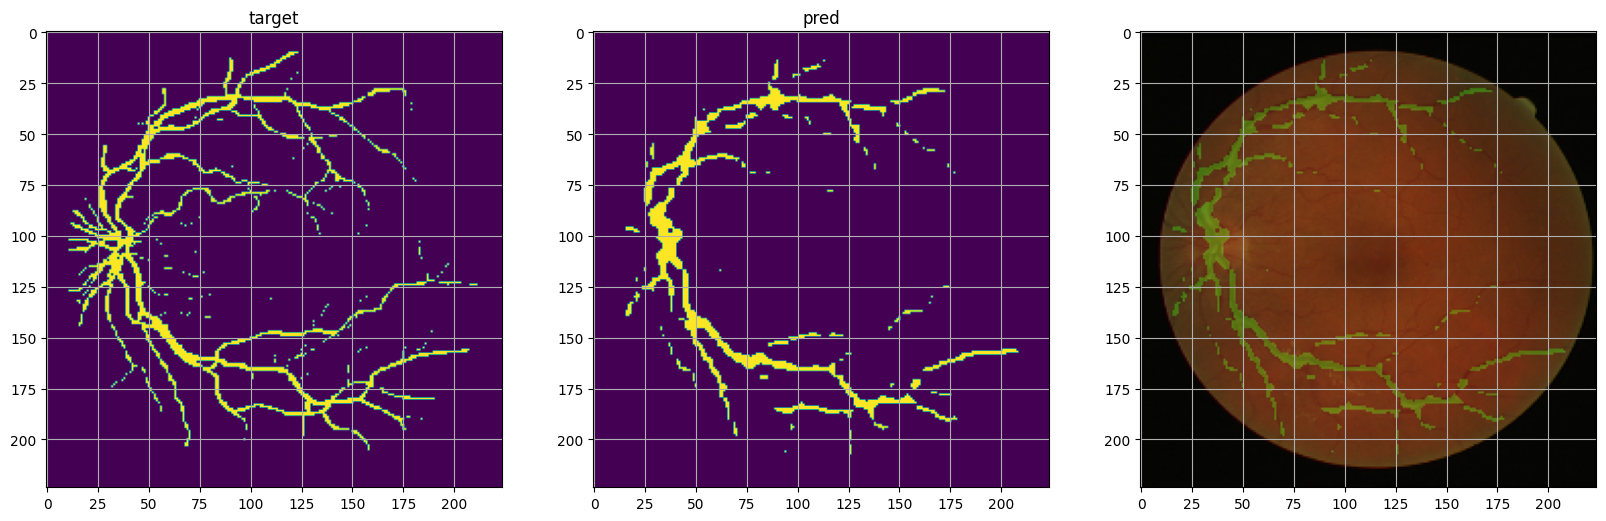

[[46182   759]
 [ 1612  1623]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     46941
         1.0       0.68      0.50      0.58      3235

    accuracy                           0.95     50176
   macro avg       0.82      0.74      0.78     50176
weighted avg       0.95      0.95      0.95     50176



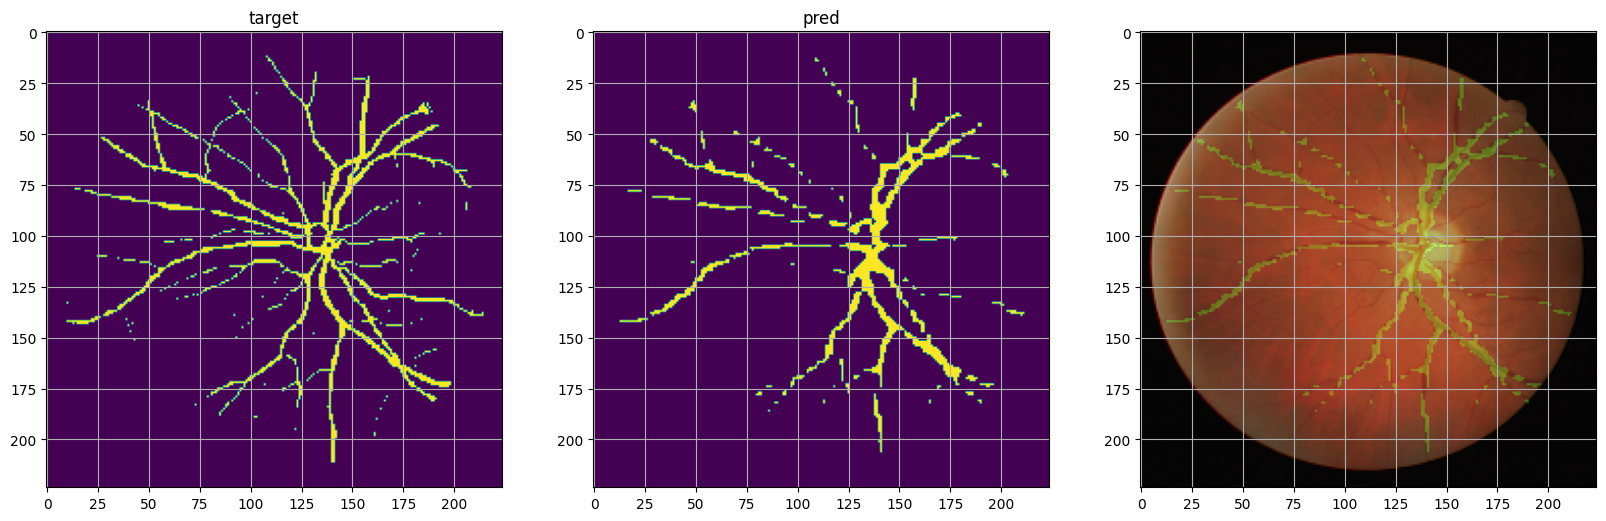

[[46521   679]
 [ 1418  1558]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     47200
         1.0       0.70      0.52      0.60      2976

    accuracy                           0.96     50176
   macro avg       0.83      0.75      0.79     50176
weighted avg       0.95      0.96      0.96     50176



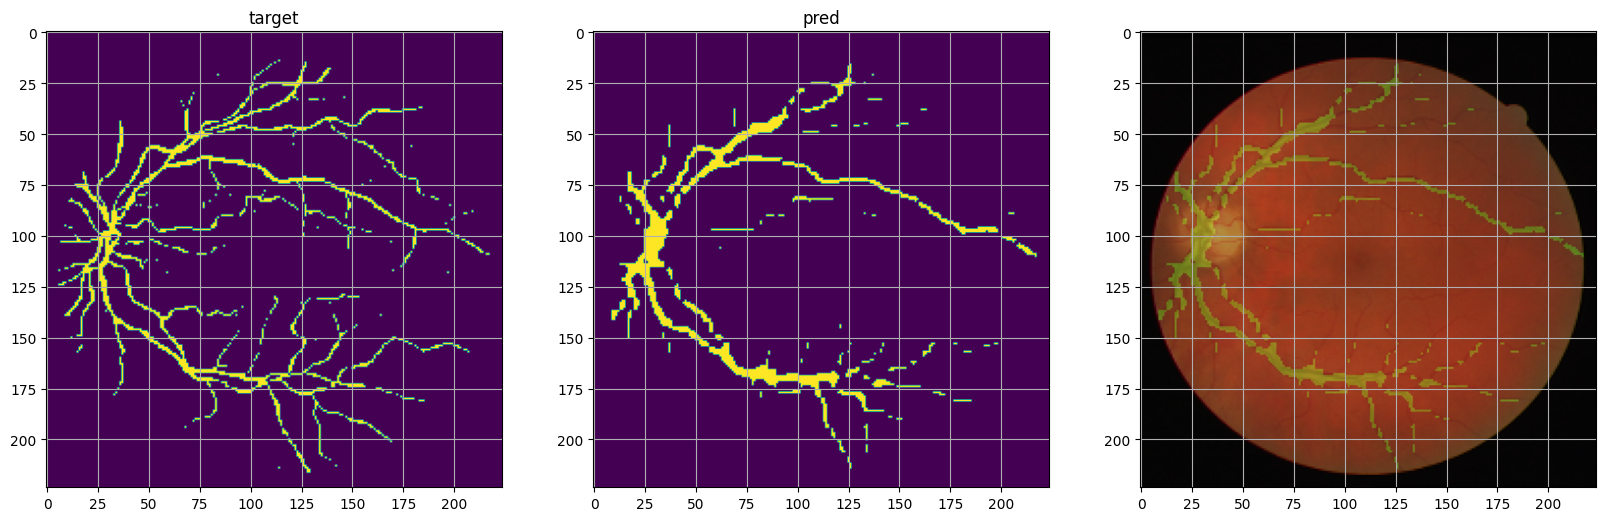

[[46374   918]
 [ 1376  1508]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     47292
         1.0       0.62      0.52      0.57      2884

    accuracy                           0.95     50176
   macro avg       0.80      0.75      0.77     50176
weighted avg       0.95      0.95      0.95     50176



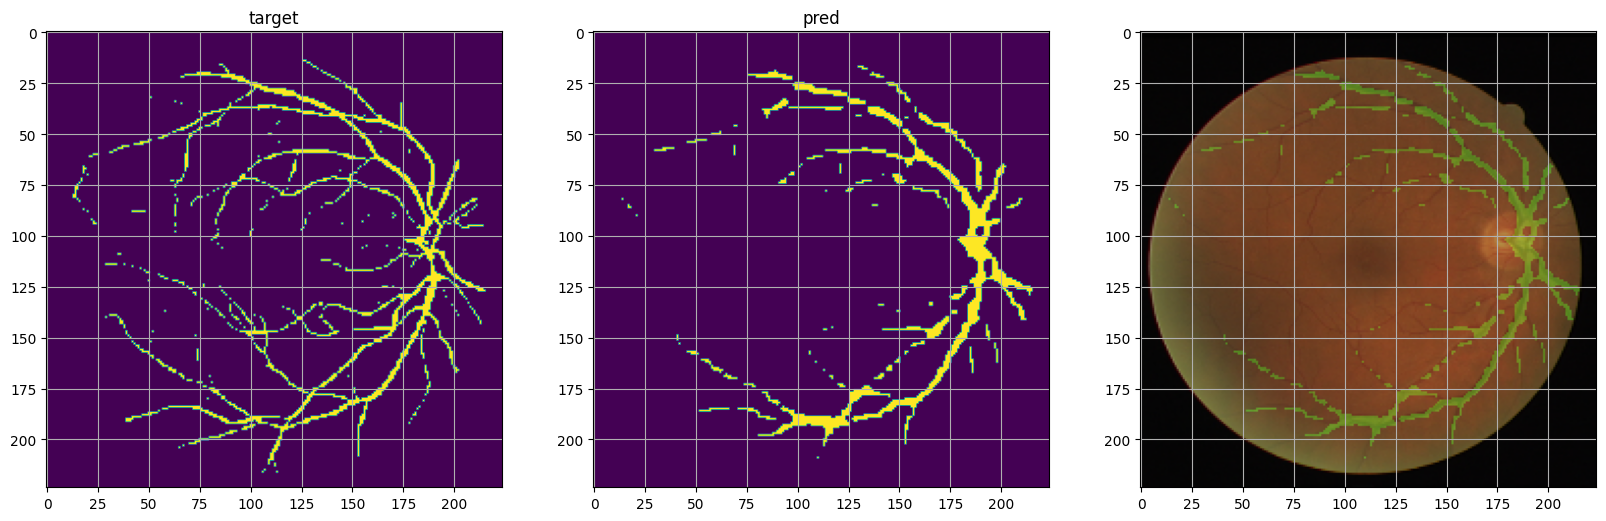

[[46343   906]
 [ 1406  1521]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     47249
         1.0       0.63      0.52      0.57      2927

    accuracy                           0.95     50176
   macro avg       0.80      0.75      0.77     50176
weighted avg       0.95      0.95      0.95     50176

1/1 [==============================] - 0s 18ms/step


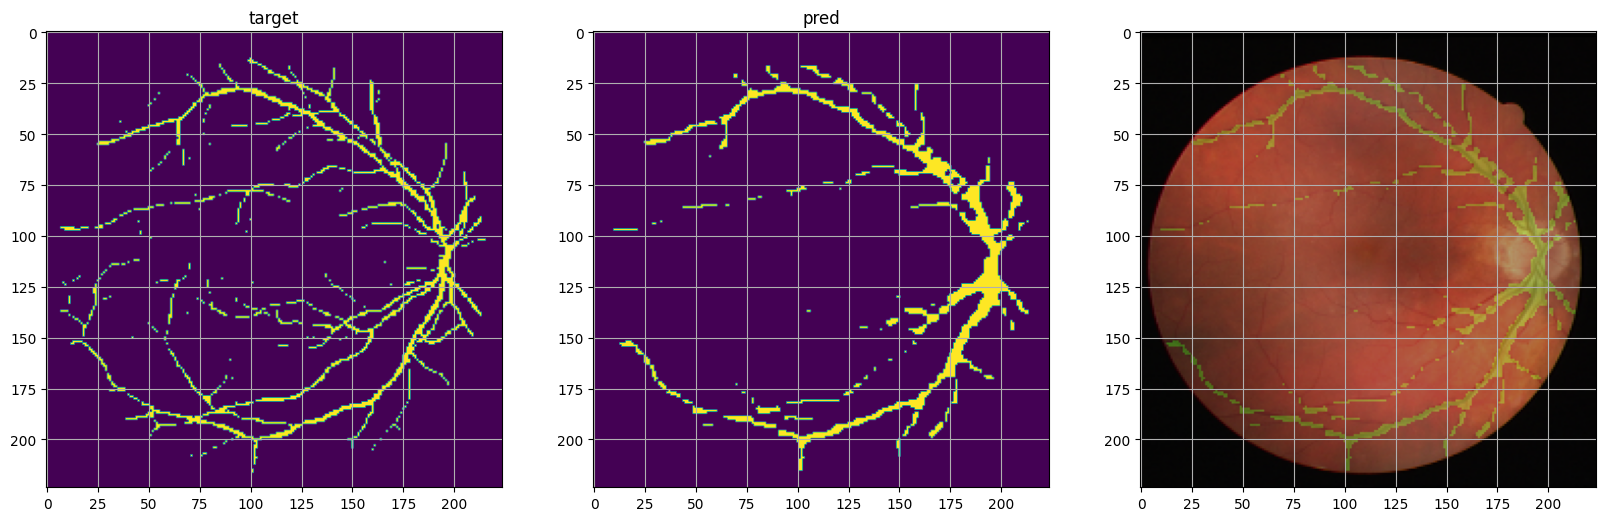

[[46142  1180]
 [ 1305  1549]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     47322
         1.0       0.57      0.54      0.55      2854

    accuracy                           0.95     50176
   macro avg       0.77      0.76      0.76     50176
weighted avg       0.95      0.95      0.95     50176



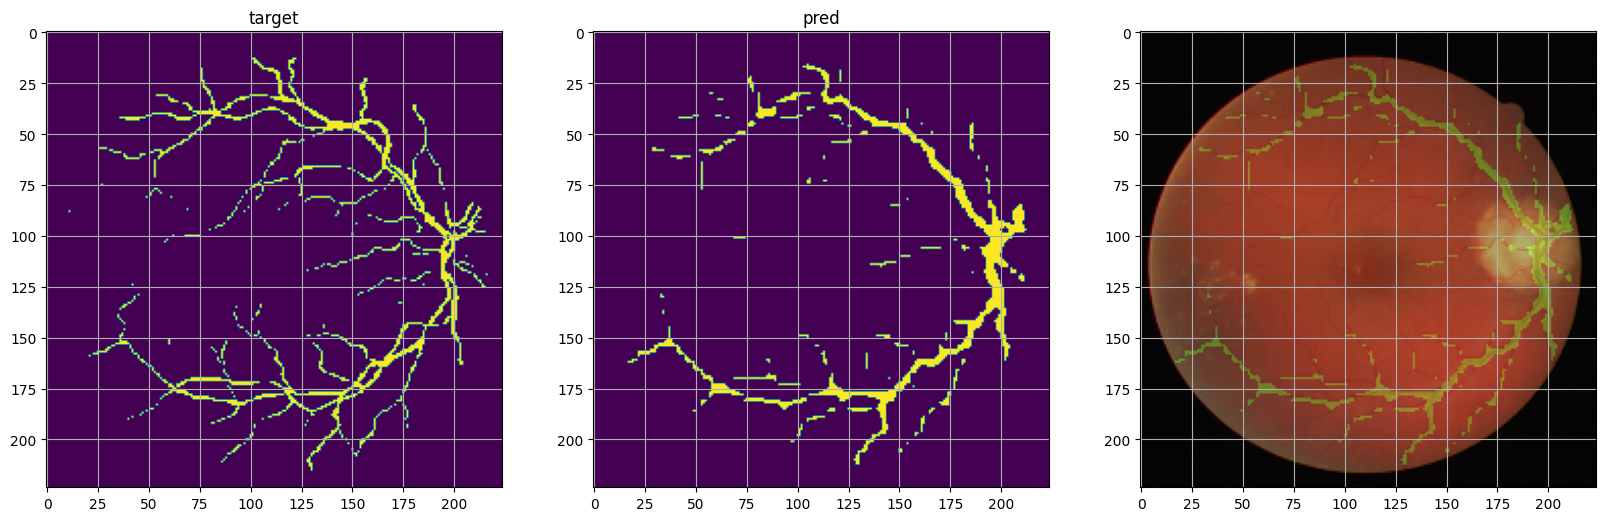

[[46636   903]
 [ 1258  1379]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     47539
         1.0       0.60      0.52      0.56      2637

    accuracy                           0.96     50176
   macro avg       0.79      0.75      0.77     50176
weighted avg       0.95      0.96      0.96     50176



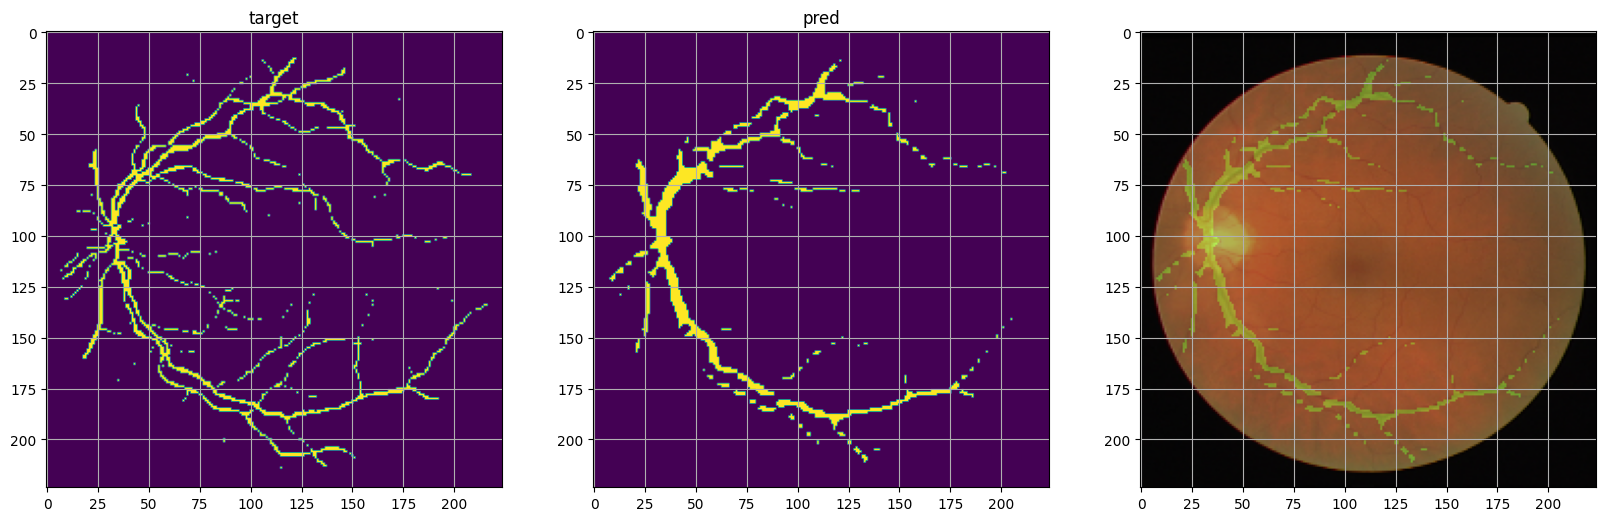

[[47020   779]
 [ 1184  1193]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47799
         1.0       0.60      0.50      0.55      2377

    accuracy                           0.96     50176
   macro avg       0.79      0.74      0.76     50176
weighted avg       0.96      0.96      0.96     50176



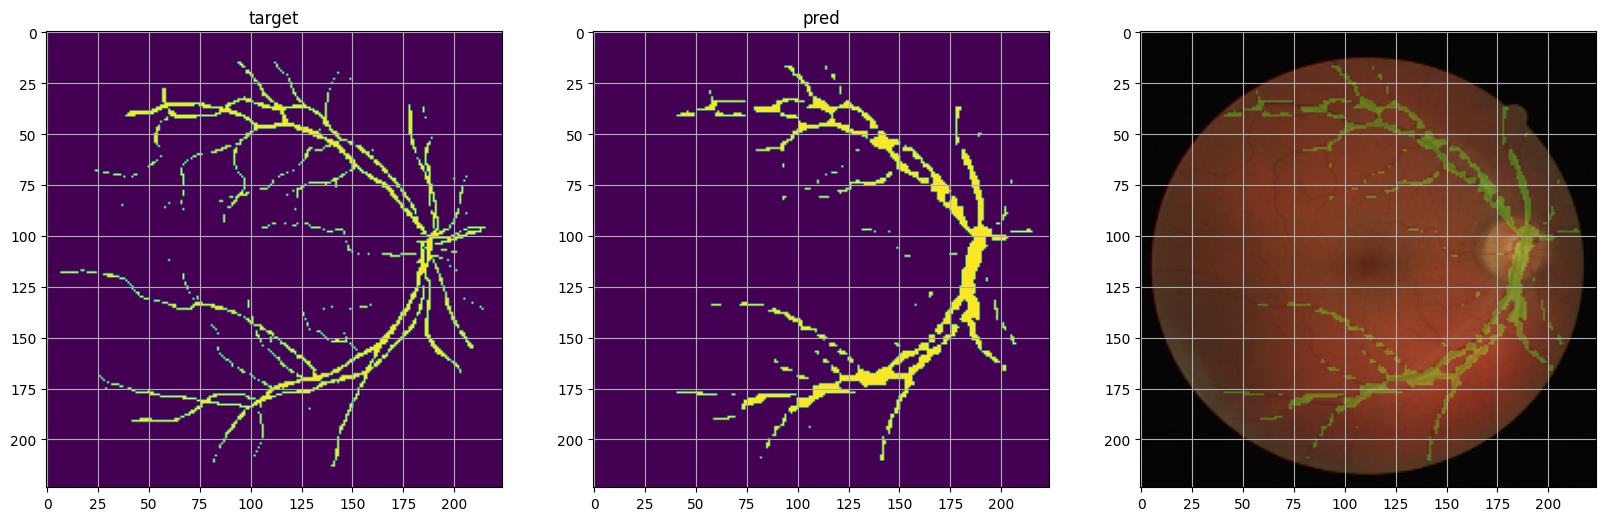

[[46611  1083]
 [ 1025  1457]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     47694
         1.0       0.57      0.59      0.58      2482

    accuracy                           0.96     50176
   macro avg       0.78      0.78      0.78     50176
weighted avg       0.96      0.96      0.96     50176



In [18]:


threshold = 0.6
for i in val_dataset:
    pred_logits = model.predict(i[0])
    

    for n in range(len(i[0])): 
        image = i[0][n].numpy().astype(np.uint8)
        pred_logit = pred_logits[n]
     #   print(pred_logit.shape)
        pred_value = np.where(pred_logit>threshold,1,0).reshape(224,224,1)
        pred_mask = (pred_value*255).astype(np.uint8)

    #    print(pred_mask.shape, image.shape)
        overlay = generate_overlay_image(pred_mask, image, alpha=0.3)
        target = i[1][n].numpy()
        np.unique(target,return_counts=True)    

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('target')
        plt.imshow(target)
        plt.grid(True)
        plt.subplot(1,3,2)
        plt.title('pred')
        plt.imshow(pred_value)
        plt.grid(True)
        plt.subplot(1,3,3)
        plt.imshow(overlay)
        plt.grid(True)
        plt.show()

        #print(pred_value.shape, target.shape)

        cm,cr = calculate_confusion_matrix_and_report(pred_value, target)
        print(cm)
        print(cr)

In [19]:
best_model_path = trainer.save_path
print(best_model_path)

models/20240916022744


### Inferencer


In [21]:
from functools import lru_cache
from typing import Dict, Union, Optional, List, Tuple, Any

import numpy as np
from omegaconf import DictConfig, ListConfig
import matplotlib.pyplot as plt 
from PIL import Image

from one_ring.deploy.inferencer import Inferencer

#

# %%
config = {
    #"image_size": [224, 224, 3],
    "model_type": "onnx",
    "model_path": best_model_path, # "best_model_path"
    "preprocessor_type": "albumentations",
    "postprocessor_type": "vanilla",
    "device": "cpu",
    "threshold":0.6
}


inferencer = Inferencer(config, cache_size=256, log_level="INFO")
inferencer

In [22]:
image_path = 'data/vessel/val_images/1.png'
image = Image.open(image_path)
image = np.array(image)

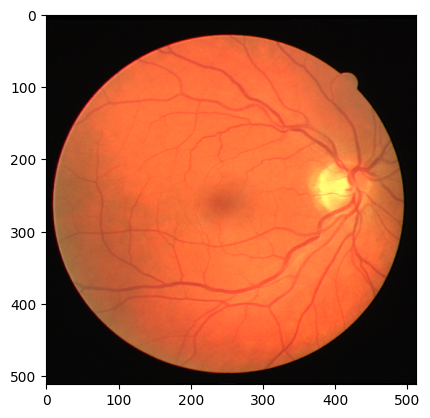

In [23]:
plt.imshow(image)
plt.show()

In [24]:
pred_mask, pred_image = inferencer(image)

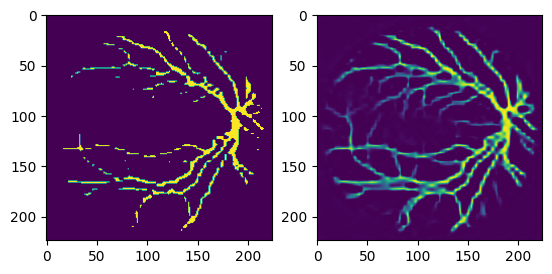

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(pred_mask[0])
plt.subplot(1, 2, 2)
plt.imshow(pred_image[0])